In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Dataset: VHM Historical Data



In [2]:
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


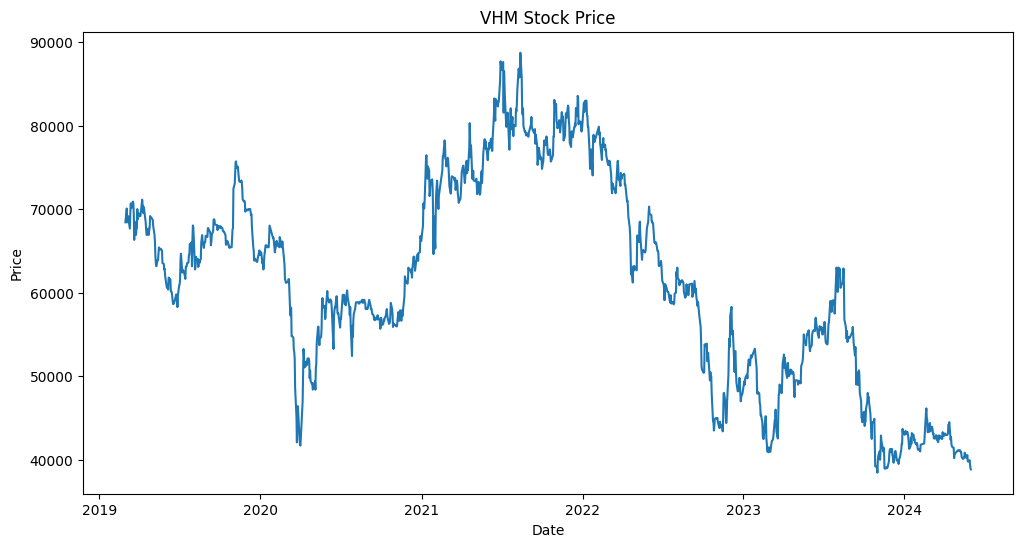

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [5]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [6]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.1516
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0195
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0081
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0063
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0057
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0046
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0040
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0040
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0037
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0038
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0038
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0034
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0038
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0033
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/st

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 2188.592618952508
Testing MAPE: 4.170657324197694
Testing MAE: 1846.9453924914676


In [14]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


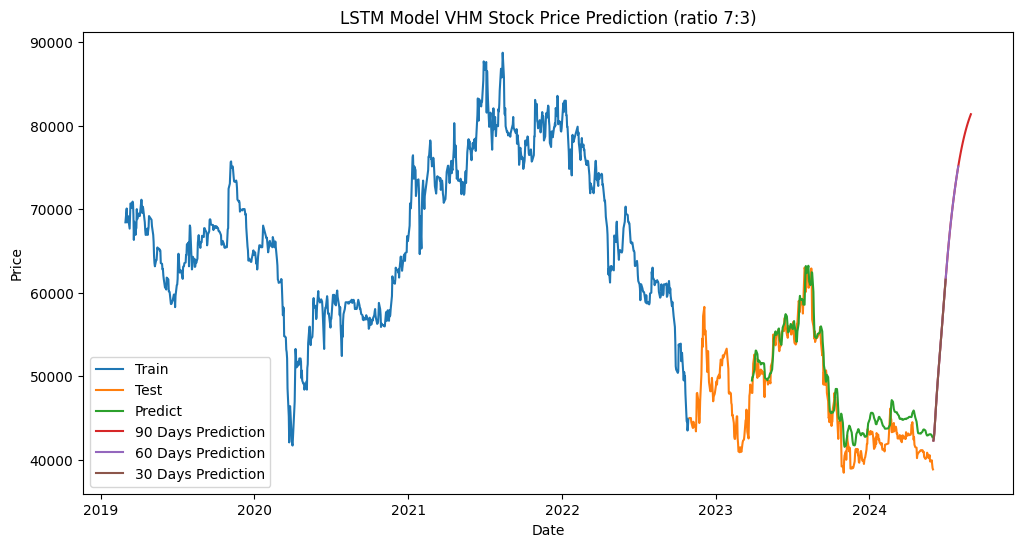

In [15]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [16]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [17]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.1780
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0206
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0084
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0061
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0044
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0046
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0047
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0047
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0041
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0042
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0039
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0040
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0038
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0038
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1363.2753369344716
Testing MAPE: 2.778356238753798
Testing MAE: 1155.3871286651236


In [25]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


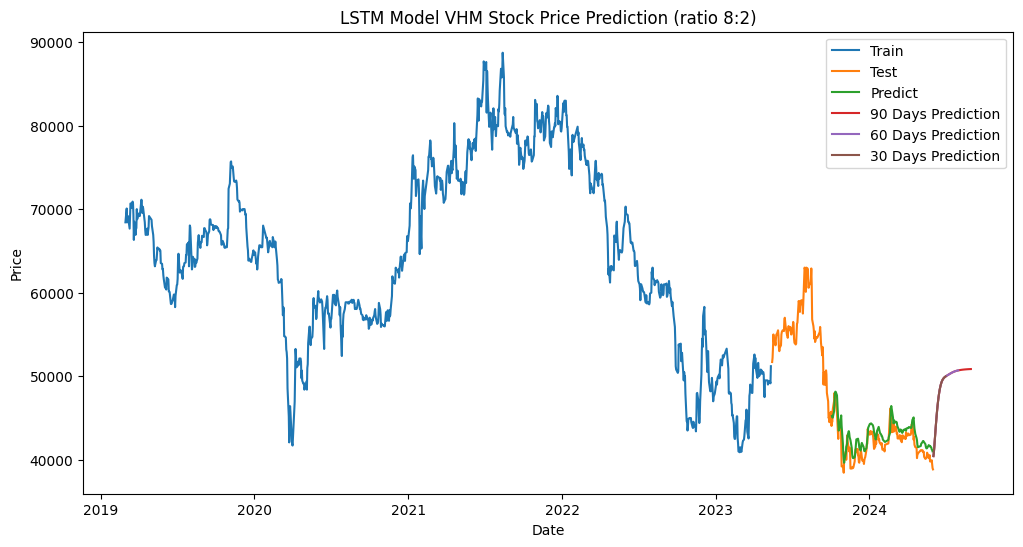

In [26]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [27]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [28]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1177
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0115
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0067
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0049
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0050
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0045
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0045
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0046
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0042
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0041
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0043
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0038
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0041
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0034
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - lo

In [33]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [35]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1025.5296199643155
Testing MAPE: 2.2011672045962802
Testing MAE: 894.3083333333333


In [36]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


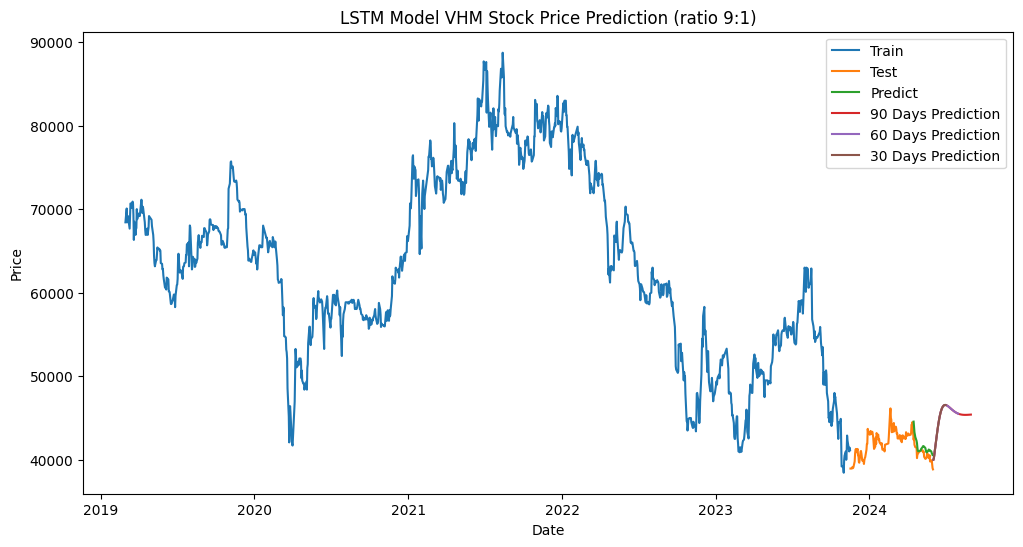

In [37]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NVL Historical Data


In [38]:
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


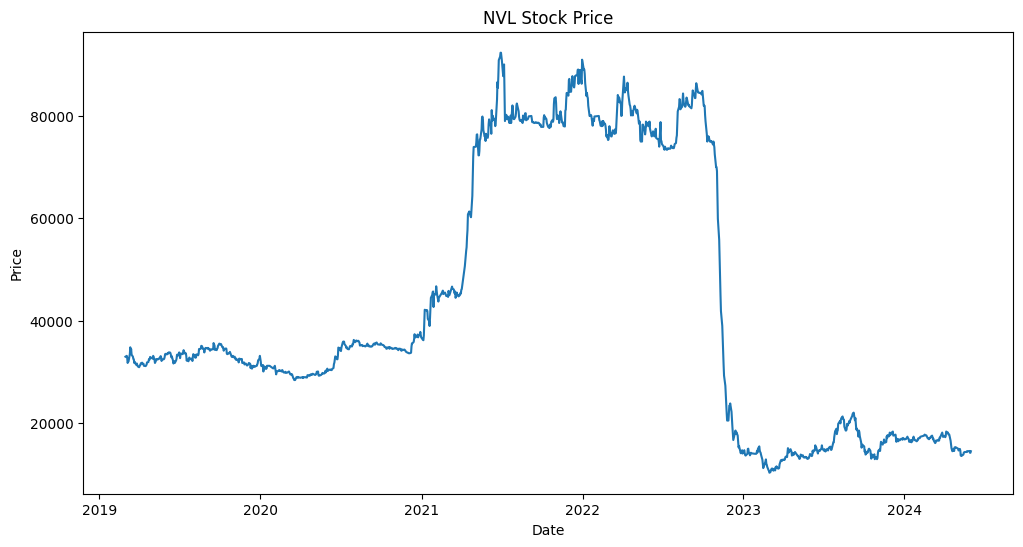

In [39]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [40]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [58]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [59]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [60]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [61]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [62]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [63]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1927
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0209
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0098
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0036
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0023
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0021
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0015
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0016
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0018
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0020
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0016
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0015
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0017
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0016
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - l

In [64]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [65]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [66]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 3052.4203729859432
Testing MAPE: 17.99119339908407
Testing MAE: 2822.31365987628


In [67]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


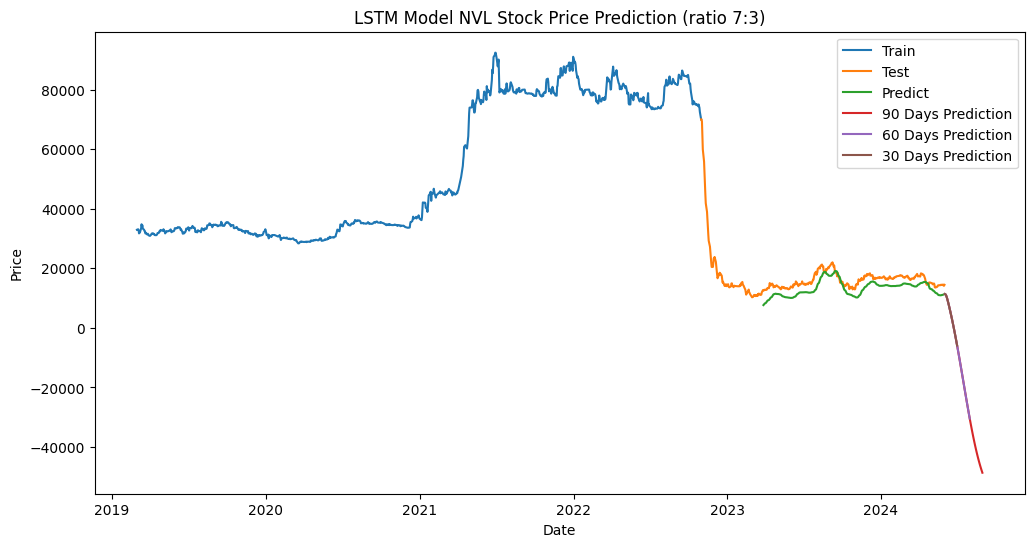

In [69]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [70]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [71]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [72]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [73]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [74]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [75]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.1618
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0193
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0053
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0032
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0037
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0033
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0024
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0028
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0020
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0024
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0021
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0015
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0018
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0017
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/ste

In [76]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [77]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [78]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 810.0517151140637
Testing MAPE: 3.9879273239465203
Testing MAE: 638.5277536651234


In [79]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


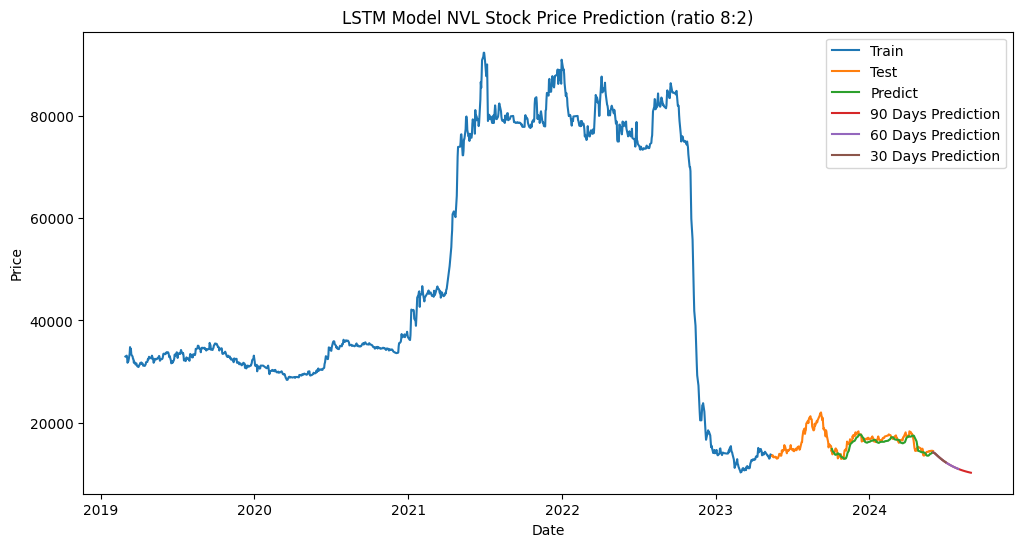

In [80]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [81]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [82]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [83]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [84]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [85]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


In [ ]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NLG Historical Data


In [ ]:
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [ ]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [ ]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


In [ ]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [ ]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [ ]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


In [ ]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [ ]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [ ]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

In [ ]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


In [ ]:
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()